Overlay scores on heatmaps

In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt

In [260]:
results_dir = "image_sets/results_2/exp_10_s1/"

Plotly overlay

In [261]:
import plotly.figure_factory as ff

plt.text overlay

In [262]:
patch_folder = "image_sets/patches/F005a02/"

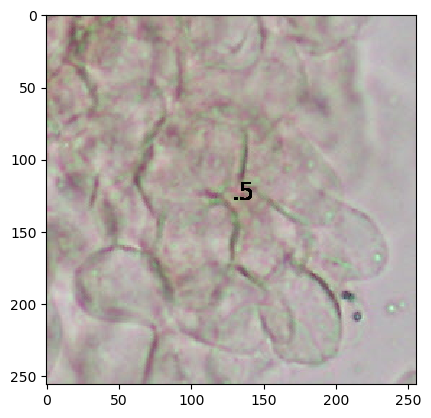

In [263]:
for patch_file in sorted(os.listdir(patch_folder)):
    img_path = os.path.join(patch_folder, patch_file)
    img = Image.open(img_path)
    plt.text(128, 128, r'.5',fontsize='xx-large')
    plt.imshow(img)

Check .pt files shape

In [264]:
import torch

In [265]:
filePath = "image_sets/patches/fungal_vs_nonfungal_resnet_features/pt_files/N009a003.pt"
a = torch.load(filePath)

In [266]:
print(a.shape)

torch.Size([24, 1, 1, 1024])


patch annotations

In [267]:
import os
import argparse
import yaml
import cv2
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

In [268]:
filename = "F033a04.tif"
dir_in = "image_sets/original/"
patch_dir = "image_sets/patches_annotated/"
threshold = 50
d = 256 # patch size

[11481, 36, 7980, 21291, 12084, 6, 5049, 15, 15147, 20211, 24564, 14586, 5454, 9150, 15027, 12894, 42, 24093, 7227, 14028, 13725, 17577, 18867, 37143]


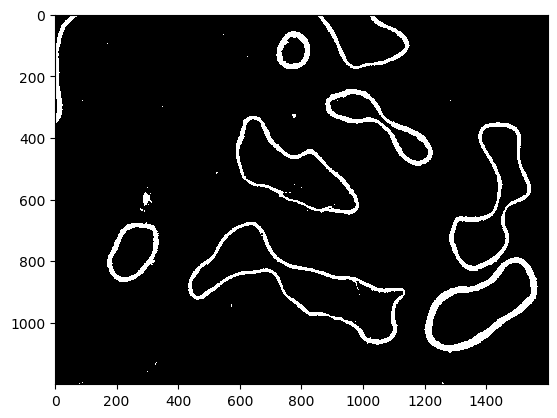

In [269]:
patch_scores = []
name, ext = os.path.splitext(filename)
dir_out = os.path.join(patch_dir, name)
img_cv = cv2.imread(os.path.join(dir_in, filename))
img_cv_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
ret, img_cv_binarized = cv2.threshold(img_cv_gray, threshold, 255, cv2.THRESH_BINARY_INV)  # Apply thresholding
img_pil_binarized = cv2.cvtColor(img_cv_binarized, cv2.COLOR_BGR2RGB)  # Convert to RGB, for PIL Image
img_pil_binarized = Image.fromarray(img_pil_binarized)  # Convert to PIL Image
w, h = img_pil_binarized.size

grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
for i, j in grid:
    box = (j, i, j+d, i+d)
    i /= 256
    j /= 256
    out = os.path.join(dir_out, f'{name}_{int(i)}_{int(j)}{ext}')

    img_patch = img_pil_binarized.crop(box)

    img_patch_np = np.asarray(img_patch)  # Convert to Numpy array
    patch_non_zero = np.count_nonzero(img_patch_np)
    patch_scores.append(patch_non_zero)

    # img_patch.save(out)  # Save patch image    

plt.imshow(img_pil_binarized)
print(patch_scores)

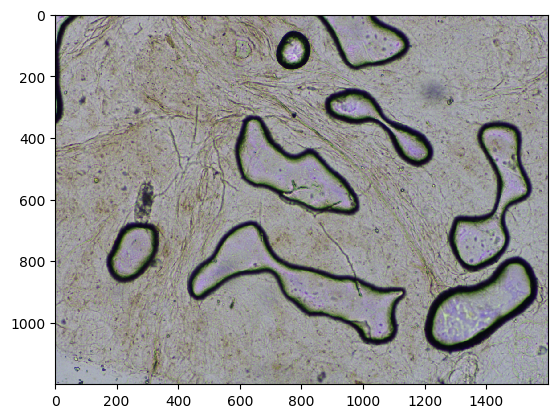

In [270]:
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

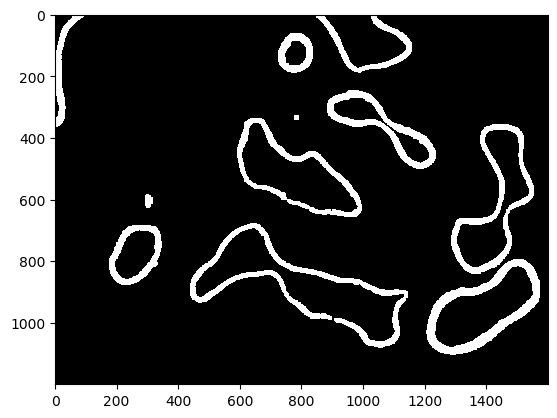

In [271]:
kernel = np.ones((2, 2), np.uint8)
img_cv_eroded = cv2.erode(img_cv_binarized.copy(), kernel, iterations=5)
img_cv_dilated = cv2.dilate(img_cv_eroded.copy(), kernel, iterations=10)
img_cv_dilated = cv2.cvtColor(img_cv_dilated, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv_dilated, cmap='gray')

In [272]:
# cv2.blur(img_cv_eroded, ())

In [273]:
print(img_cv_dilated.shape)
print(img_cv_gray.shape)

(1200, 1600, 3)
(1200, 1600)


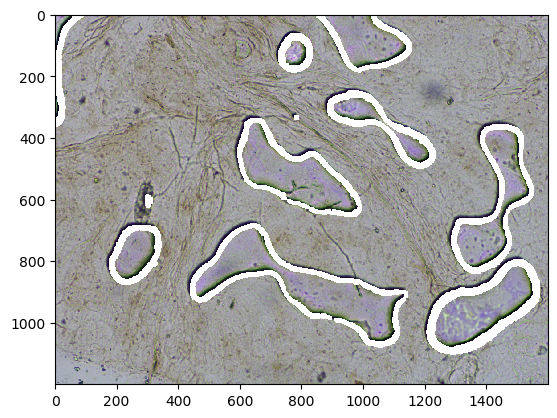

In [274]:
# new = cv2.addWeighted(img_cv_gray, 1, img_cv_eroded, 2, 0)
new = cv2.add(img_cv, img_cv_dilated)
plt.imshow(cv2.cvtColor(new, cv2.COLOR_BGR2RGB))